In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("ewing-data.csv")
# data = pd.read_csv("leukemia.csv")
# from lifelines.datasets import load_rossi, load_kidney_transplant
# data = load_rossi()
# data = load_kidney_transplant()

In [3]:
data.columns

Index(['treat', 'ldh', 'time', 'outcome'], dtype='object')

In [4]:
data.describe()

,treat,ldh,time,outcome
count,76.000000,76.000000,76.000000,76.000000
mean,0.618421,0.407895,1110.342105,0.605263
std,0.489002,0.494709,941.904985,0.492042
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,337.750000,0.000000
50%,1.000000,0.000000,882.000000,1.000000
75%,1.000000,1.000000,1660.250000,1.000000
max,1.000000,1.000000,3743.000000,1.000000


In [5]:
col_Z = 'ldh' # 'race''paro''mar'
col_X = 'treat' # fin
col_time = 'time' # week
col_status = 'outcome' # arrest
max_time = int(data[col_time].max())

In [6]:
print("X=0:", data[(data[col_X] == 0)].shape[0])
print("X=1:", data[(data[col_X] == 1)].shape[0])
print("Z=0:", data[(data[col_Z] == 0)].shape[0])
print("Z=1:", data[(data[col_Z] == 1)].shape[0])

X=0: 29
X=1: 47
Z=0: 45
Z=1: 31


In [7]:
def label_survival(row, index):
    if ((row[col_time] <= (index + 0.5)) & (row[col_status] == 1)): # time
        return 1
    return 0

In [8]:
for i in range(max_time):
    col_name = 'Y' + str(i)
    data[col_name] = data.apply(lambda row: label_survival(row, i), axis=1)

In [9]:
data
#data[['Y24', 'Y25', 'Y26', 'Y27', 'Y28', 'Y29']]

,treat,ldh,time,outcome,Y0,Y1,Y2,Y3,Y4,Y5,...,Y3733,Y3734,Y3735,Y3736,Y3737,Y3738,Y3739,Y3740,Y3741,Y3742
0,1,0,31,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
1,1,0,335,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
2,1,0,366,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,1,0,426,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
4,1,0,456,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0,1,457,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
72,0,1,761,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
73,0,1,1249,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
74,0,1,1310,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


---

In [10]:
# lets pick sex, drug, Y0
col_name = 'Y45'
subdata = data[[col_Z, col_X, col_name]] # sex, drug
subdata = subdata.rename(columns={col_Z: "Z", col_X: "X"}) # sex, drug
subdata["X"]= subdata["X"].astype(int) 
subdata["Z"]= subdata["Z"].astype(int) 
subdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
Z      76 non-null int64
X      76 non-null int64
Y45    76 non-null int64
dtypes: int64(3)
memory usage: 1.9 KB


In [11]:
subdata

,Z,X,Y45
0,0,1,1
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
71,1,0,0
72,1,0,0
73,1,0,0
74,1,0,0


In [12]:
subdata_counted = pd.DataFrame(columns=['Z', 'X', col_name, 'c', 'p'])
population_count = subdata.shape[0]

for i in range(2):
    for j in range(2):
        for k in range(2):
            count = subdata[(subdata['Z'] == i) & (subdata['X'] == j) & (subdata[col_name] == k)].shape[0]
            subdata_counted.loc[2*2*i+2*j+k] = [i, j, k, count, count/population_count]
            
subdata_counted

,Z,X,Y45,c,p
0,0.0,0.0,0.0,10.0,0.131579
1,0.0,0.0,1.0,0.0,0.000000
2,0.0,1.0,0.0,34.0,0.447368
3,0.0,1.0,1.0,1.0,0.013158
4,1.0,0.0,0.0,19.0,0.250000
5,1.0,0.0,1.0,0.0,0.000000
6,1.0,1.0,0.0,11.0,0.144737
7,1.0,1.0,1.0,1.0,0.013158


In [13]:
ipw = []

for i in range(2):
    for j in range(2):
        x = i
        z = j
        p_xz = subdata[(subdata['Z'] == z) & (subdata['X'] == x)].shape[0]
        p_z = subdata[(subdata['Z'] == z)].shape[0]
        if (p_z == 0):
            p_x_given_z = 1
        else:
            p_x_given_z = p_xz / p_z
        ipw.append(p_x_given_z)

ipw

[0.2222222222222222,
 0.6129032258064516,
 0.7777777777777778,
 0.3870967741935484]

In [14]:
# subdata[(subdata['Z'] == 0) & (subdata['X'] == 0)].shape[0]
# subdata[(subdata['Z'] == 0)].shape[0]

In [15]:
def get_adj_p(row):
    return row['p'] / ipw[(int) (row['X'] * 2 + row['Z'])]

In [16]:
subdata_counted['p_adj'] = subdata_counted.apply(lambda row: get_adj_p(row), axis=1)
subdata_counted

,Z,X,Y45,c,p,p_adj
0,0.0,0.0,0.0,10.0,0.131579,0.592105
1,0.0,0.0,1.0,0.0,0.000000,0.000000
2,0.0,1.0,0.0,34.0,0.447368,0.575188
3,0.0,1.0,1.0,1.0,0.013158,0.016917
4,1.0,0.0,0.0,19.0,0.250000,0.407895
5,1.0,0.0,1.0,0.0,0.000000,0.000000
6,1.0,1.0,0.0,11.0,0.144737,0.373904
7,1.0,1.0,1.0,1.0,0.013158,0.033991


In [17]:
subdata_counted['c_adj'] = (population_count/2) * subdata_counted['p_adj']
subdata_counted

,Z,X,Y45,c,p,p_adj,c_adj
0,0.0,0.0,0.0,10.0,0.131579,0.592105,22.500000
1,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000
2,0.0,1.0,0.0,34.0,0.447368,0.575188,21.857143
3,0.0,1.0,1.0,1.0,0.013158,0.016917,0.642857
4,1.0,0.0,0.0,19.0,0.250000,0.407895,15.500000
5,1.0,0.0,1.0,0.0,0.000000,0.000000,0.000000
6,1.0,1.0,0.0,11.0,0.144737,0.373904,14.208333
7,1.0,1.0,1.0,1.0,0.013158,0.033991,1.291667


---

In [18]:
backup = data.copy()
# data = backup.copy()

In [19]:
ipw = []
population_count = data.shape[0]

count_x0 = data[data[col_X] == 0].shape[0]
count_x1 = data[data[col_X] == 1].shape[0]

def get_adj_p(row, index):
        return row['p_'+str(index)] / ipw[(int) (row['X'] * 2 + row['Z'])]
    
clustered_data = pd.DataFrame(columns=['Z', 'X', 'Y']) # c0, p0, c_adj_0, p_adj_0
for i in range(2):
    for j in range(2):
        for k in range(2):
            clustered_data.loc[2*2*i+2*j+k] = [i, j, k]

for m in range(max_time): # 45, 46
    
    col_name = 'Y' + str(m)
    clustered_data['c_' + str(m)] = 0
    
    for i in range(2):
        for j in range(2):
            for k in range(2):
                clustered_data.at[2*2*i+2*j+k, 'c_' + str(m)] = data[(data[col_Z] == i) & (data[col_X] == j) & (data[col_name] == k)].shape[0]

    clustered_data['p_' + str(m)] = clustered_data['c_' + str(m)] / population_count
            
    ipw = []

    for i in range(2):
        for j in range(2):
            p_xz = data[(data[col_Z] == j) & (data[col_X] == i)].shape[0]
            p_z = data[(data[col_Z] == j)].shape[0]
            if (p_z == 0):
                p_x_given_z = 1
            else:
                p_x_given_z = p_xz / p_z
            ipw.append(p_x_given_z)
    
    clustered_data['p_adj_'+str(m)] = clustered_data.apply(lambda row: get_adj_p(row, m), axis=1)
    count_of_treatment = count_x0 * (1-clustered_data['X']) + count_x1 * clustered_data['X']
    clustered_data['c_adj_'+str(m)] = clustered_data['p_adj_'+str(m)] * count_of_treatment
#     clustered_data['c_adj_'+str(m)] = (population_count/2) * clustered_data['p_adj_'+str(m)]
    
print(ipw)

[0.2222222222222222, 0.6129032258064516, 0.7777777777777778, 0.3870967741935484]


In [20]:
clustered_data

,Z,X,Y,c_0,p_0,p_adj_0,c_adj_0,c_1,p_1,p_adj_1,...,p_adj_3740,c_adj_3740,c_3741,p_3741,p_adj_3741,c_adj_3741,c_3742,p_3742,p_adj_3742,c_adj_3742
0,0,0,0,10,0.131579,0.592105,17.1711,10,0.131579,0.592105,...,0.355263,10.3026,6,0.078947,0.355263,10.3026,6,0.078947,0.355263,10.3026
1,0,0,1,0,0.000000,0.000000,0,0,0.000000,0.000000,...,0.236842,6.86842,4,0.052632,0.236842,6.86842,4,0.052632,0.236842,6.86842
2,0,1,0,35,0.460526,0.592105,27.8289,35,0.460526,0.592105,...,0.389098,18.2876,23,0.302632,0.389098,18.2876,23,0.302632,0.389098,18.2876
3,0,1,1,0,0.000000,0.000000,0,0,0.000000,0.000000,...,0.203008,9.54135,12,0.157895,0.203008,9.54135,12,0.157895,0.203008,9.54135
4,1,0,0,19,0.250000,0.407895,11.8289,19,0.250000,0.407895,...,0.021468,0.622576,1,0.013158,0.021468,0.622576,1,0.013158,0.021468,0.622576
5,1,0,1,0,0.000000,0.000000,0,0,0.000000,0.000000,...,0.386427,11.2064,18,0.236842,0.386427,11.2064,18,0.236842,0.386427,11.2064
6,1,1,0,11,0.144737,0.373904,17.5735,11,0.144737,0.373904,...,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0
7,1,1,1,1,0.013158,0.033991,1.59759,1,0.013158,0.033991,...,0.407895,19.1711,12,0.157895,0.407895,19.1711,12,0.157895,0.407895,19.1711


In [21]:
print("X=0:", data[(data[col_X] == 0)].shape[0])
print("X=1:", data[(data[col_X] == 1)].shape[0])
print("Z=0:", data[(data[col_Z] == 0)].shape[0])
print("Z=1:", data[(data[col_Z] == 1)].shape[0])

X=0: 29
X=1: 47
Z=0: 45
Z=1: 31


In [22]:
a = clustered_data[(clustered_data['X'] == 0) & (clustered_data['Y'] == 0)]['c_45'].sum()
print(a)
b = clustered_data[(clustered_data['X'] == 0)]['c_45'].sum()
print(b)
print("count:", a/b) 

29
29
count: 1.0


In [23]:
a = clustered_data[(clustered_data['X'] == 0) & (clustered_data['Y'] == 0)]['p_45'].sum()
print(a)
b = clustered_data[(clustered_data['X'] == 0)]['p_45'].sum()
print(b)
print("probablities:", a/b) 

0.381578947368421
0.381578947368421
probablities: 1.0


In [24]:
a = clustered_data[(clustered_data['X'] == 0) & (clustered_data['Y'] == 0)]['p_adj_45'].sum()
print(a)
b = clustered_data[(clustered_data['X'] == 0)]['p_adj_45'].sum()
print(b)
print("adjusted:", a/b) 

1.0
1.0
adjusted: 1.0


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


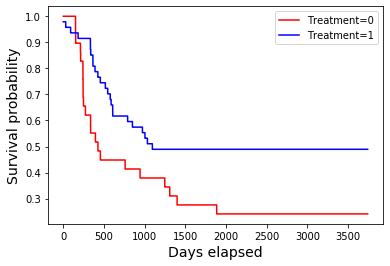

In [25]:
t = []
x0 = []
x1 = []

for i in range(max_time):
    t.append(i)
    
    a = clustered_data[(clustered_data['X'] == 0) & (clustered_data['Y'] == 0)]['p_'+str(i)].sum()
    b = clustered_data[(clustered_data['X'] == 0)]['p_'+str(i)].sum()
    x0.append(a/b)
    
    a = clustered_data[(clustered_data['X'] == 1) & (clustered_data['Y'] == 0)]['p_'+str(i)].sum()
    b = clustered_data[(clustered_data['X'] == 1)]['p_'+str(i)].sum()
    x1.append(a/b)

plt.figure()
plt.step(t, x0, 'r', label='Treatment=0') # plotting t, a separately 
plt.step(t, x1, 'b', label='Treatment=1') # plotting t, b separately 
plt.legend()
plt.xlabel('Days elapsed', fontsize=14)
plt.ylabel('Survival probability', fontsize=14)
# plt.show() 
plt.savefig('unadjusted_ewing.eps', format='eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


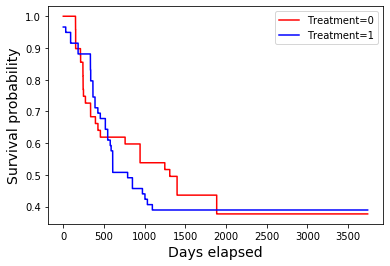

In [26]:
t = []
x0_adj = []
x1_adj = []

for i in range(max_time):
    t.append(i)
    
    a = clustered_data[(clustered_data['X'] == 0) & (clustered_data['Y'] == 0)]['p_adj_'+str(i)].sum()
    b = clustered_data[(clustered_data['X'] == 0)]['p_adj_'+str(i)].sum()
    x0_adj.append(a/b)
    
    a = clustered_data[(clustered_data['X'] == 1) & (clustered_data['Y'] == 0)]['p_adj_'+str(i)].sum()
    b = clustered_data[(clustered_data['X'] == 1)]['p_adj_'+str(i)].sum()
    x1_adj.append(a/b)

# plt.figure(figsize=(18,8))
plt.figure()
plt.step(t, x0_adj, 'r', label='Treatment=0') # plotting t, a separately 
plt.step(t, x1_adj, 'b', label='Treatment=1') # plotting t, b separately
plt.legend()
plt.xlabel('Days elapsed', fontsize=14)
plt.ylabel('Survival probability', fontsize=14)
# plt.show() 
plt.savefig('adjusted_ewing.eps', format='eps')

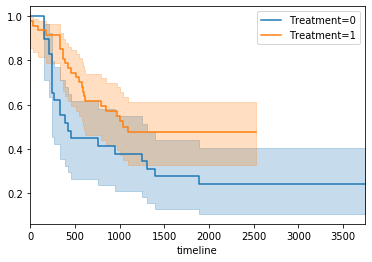

In [27]:
from lifelines import KaplanMeierFitter

ix = (data[col_X] == 1)

kmf = KaplanMeierFitter()
kmf.fit(data[col_time][~ix], data[col_status][~ix], label='Treatment=0')
ax = kmf.plot_survival_function()

kmf = KaplanMeierFitter()
kmf.fit(data[col_time][ix], data[col_status][ix], label='Treatment=1')
ax = kmf.plot_survival_function(ax=ax)

In [28]:
print('x1\tx1_adj\tdiff')
print('------\t------\t------')
for i in range(len(x1)):
    print('%.4f'%x1[i], '%.4f'%x1_adj[i], '%.4f'%(x1[i]-x1_adj[i]), sep="\t")

x1	x1_adj	diff
------	------	------
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9787	0.9660	0.0127
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.0084
0.9574	0.9491	0.008

0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6596	0.5757	0.0839
0.6383	0.5417	0.0966
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077	0.1093
0.6170	0.5077

0.5106	0.4060	0.1046
0.5106	0.4060	0.1046
0.5106	0.4060	0.1046
0.5106	0.4060	0.1046
0.5106	0.4060	0.1046
0.5106	0.4060	0.1046
0.5106	0.4060	0.1046
0.5106	0.4060	0.1046
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891

0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891

0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891

0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891

0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891

0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891	0.1003
0.4894	0.3891

---

# Now lets calculate the adjusted survival dataset

In [29]:
clustered_data

,Z,X,Y,c_0,p_0,p_adj_0,c_adj_0,c_1,p_1,p_adj_1,...,p_adj_3740,c_adj_3740,c_3741,p_3741,p_adj_3741,c_adj_3741,c_3742,p_3742,p_adj_3742,c_adj_3742
0,0,0,0,10,0.131579,0.592105,17.1711,10,0.131579,0.592105,...,0.355263,10.3026,6,0.078947,0.355263,10.3026,6,0.078947,0.355263,10.3026
1,0,0,1,0,0.000000,0.000000,0,0,0.000000,0.000000,...,0.236842,6.86842,4,0.052632,0.236842,6.86842,4,0.052632,0.236842,6.86842
2,0,1,0,35,0.460526,0.592105,27.8289,35,0.460526,0.592105,...,0.389098,18.2876,23,0.302632,0.389098,18.2876,23,0.302632,0.389098,18.2876
3,0,1,1,0,0.000000,0.000000,0,0,0.000000,0.000000,...,0.203008,9.54135,12,0.157895,0.203008,9.54135,12,0.157895,0.203008,9.54135
4,1,0,0,19,0.250000,0.407895,11.8289,19,0.250000,0.407895,...,0.021468,0.622576,1,0.013158,0.021468,0.622576,1,0.013158,0.021468,0.622576
5,1,0,1,0,0.000000,0.000000,0,0,0.000000,0.000000,...,0.386427,11.2064,18,0.236842,0.386427,11.2064,18,0.236842,0.386427,11.2064
6,1,1,0,11,0.144737,0.373904,17.5735,11,0.144737,0.373904,...,0.000000,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0
7,1,1,1,1,0.013158,0.033991,1.59759,1,0.013158,0.033991,...,0.407895,19.1711,12,0.157895,0.407895,19.1711,12,0.157895,0.407895,19.1711


In [30]:
adj_data = pd.DataFrame(columns=['Z', 'X', 'Y', 'status'])

for i in range(4): # 4
    z = i//2
    x = i%2
    
    death_by_time = []
    sub_clustered_data = clustered_data[(clustered_data['Z'] == z) & (clustered_data['X'] == x) & (clustered_data['Y'] == 1)]
    
    dead_prev = 0
    for k in range(max_time):
        dead_now = round(sub_clustered_data['c_adj_' + str(k)][i*2+1])
        died_this_day = dead_now - dead_prev
        
        if (died_this_day != 0):
            for m in range(died_this_day):
                adj_data = adj_data.append({'Z': i//2 , 'X': i%2, 'Y': k, 'status': 1} , ignore_index=True)
                
        dead_prev = dead_now
              
    alive_now = round(clustered_data['c_adj_' + str(max_time-1)][i*2])
    if (alive_now != 0):
        for m in range(alive_now):
            adj_data = adj_data.append({'Z': i//2 , 'X': i%2, 'Y': max_time, 'status': 0} , ignore_index=True)
    
    # delete later
#     break
                
adj_data

,Z,X,Y,status
0,0,0,153,1
1,0,0,153,1
2,0,0,945,1
3,0,0,1400,1
4,0,0,1400,1
...,...,...,...,...
71,1,1,608,1
72,1,1,608,1
73,1,1,609,1
74,1,1,609,1


In [31]:
adj_data['Z'] = adj_data.Z.astype(float)
adj_data['X'] = adj_data.X.astype(float)
adj_data['Y'] = adj_data.Y.astype(float)
adj_data['status'] = adj_data.status.astype(float)

In [32]:
adj_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 4 columns):
Z         76 non-null float64
X         76 non-null float64
Y         76 non-null float64
status    76 non-null float64
dtypes: float64(4)
memory usage: 2.5 KB


In [33]:
adj_data.describe()

,Z,X,Y,status
count,76.000000,76.000000,76.000000,76.000000
mean,0.407895,0.618421,1774.526316,0.618421
std,0.494709,0.489002,1596.421661,0.489002
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,358.250000,0.000000
50%,0.000000,1.000000,959.500000,1.000000
75%,1.000000,1.000000,3743.000000,1.000000
max,1.000000,1.000000,3743.000000,1.000000


In [34]:
print("X=0:", adj_data[(adj_data['X'] == 0)].shape[0])
print("X=1:", adj_data[(adj_data['X'] == 1)].shape[0])
print("Z=0:", adj_data[(adj_data['Z'] == 0)].shape[0])
print("Z=1:", adj_data[(adj_data['Z'] == 1)].shape[0])

X=0: 29
X=1: 47
Z=0: 45
Z=1: 31


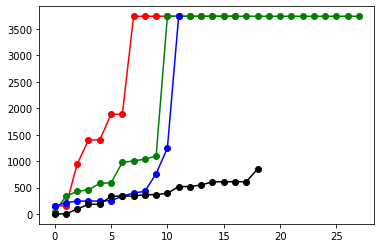

In [35]:
time00 = adj_data[(adj_data['Z'] == 0) & (adj_data['X'] == 0)].sort_values(by='Y', ascending=True)['Y']
time01 = adj_data[(adj_data['Z'] == 0) & (adj_data['X'] == 1)].sort_values(by='Y', ascending=True)['Y']
time10 = adj_data[(adj_data['Z'] == 1) & (adj_data['X'] == 0)].sort_values(by='Y', ascending=True)['Y']
time11 = adj_data[(adj_data['Z'] == 1) & (adj_data['X'] == 1)].sort_values(by='Y', ascending=True)['Y']

plt.plot(range(len(time00)), time00, 'r-o')
plt.plot(range(len(time01)), time01, 'g-o')
plt.plot(range(len(time10)), time10, 'b-o')
plt.plot(range(len(time11)), time11, 'k-o')

---

# Survival Analysis with CoxPHFitter

In [36]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import plot_lifetimes

In [37]:
data_without_sex = adj_data[['X', 'Y', 'status']].copy()
data_without_sex.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 3 columns):
X         76 non-null float64
Y         76 non-null float64
status    76 non-null float64
dtypes: float64(3)
memory usage: 1.9 KB


In [38]:
data_without_sex

,X,Y,status
0,0.0,153.0,1.0
1,0.0,153.0,1.0
2,0.0,945.0,1.0
3,0.0,1400.0,1.0
4,0.0,1400.0,1.0
...,...,...,...
71,1.0,608.0,1.0
72,1.0,608.0,1.0
73,1.0,609.0,1.0
74,1.0,609.0,1.0


In [39]:
cph = CoxPHFitter()
cph.fit(data_without_sex, 'Y', 'status', show_progress=True)
cph.print_summary()

Iteration 3: norm_delta = 0.00004, step_size = 0.9500, ll = -184.95859, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 3 iterations.
<lifelines.CoxPHFitter: fitted with 76 total observations, 29 right-censored observations>
             duration col = 'Y'
                event col = 'status'
   number of observations = 76
number of events observed = 47
   partial log-likelihood = -184.96
         time fit was run = 2020-03-29 03:41:21 UTC

---
    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
X   0.03       1.03       0.30            -0.56             0.62                 0.57                 1.86

     z    p   -log2(p)
X 0.10 0.92       0.13
---
Concordance = 0.50
Log-likelihood ratio test = 0.01 on 1 df, -log2(p)=0.13


In [40]:
# Iteration 4: norm_delta = 0.00003, step_size = 1.0000, ll = -128.27364, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 4 iterations.
# <lifelines.CoxPHFitter: fitted with 45 total observations, 0 right-censored observations>
#              duration col = 'Y'
#                 event col = 'status'
#    number of observations = 45
# number of events observed = 45
#    partial log-likelihood = -128.27
#          time fit was run = 2020-03-18 18:43:54 UTC

# ---
#     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
# X   0.43       1.54       0.33            -0.22             1.08                 0.80                 2.96

#      z    p   -log2(p)
#     X 1.30 0.20       2.36
# ---
# Concordance = 0.50
# Log-likelihood ratio test = 1.70 on 1 df, -log2(p)=2.38

---

# Survival Analysis on real data

In [41]:
data = pd.read_csv("ewing-data.csv")

In [42]:
cph2 = CoxPHFitter()
cph2.fit(data, 'time', 'outcome', show_progress=True)
cph2.print_summary()

Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -159.45884, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 5 iterations.
<lifelines.CoxPHFitter: fitted with 76 total observations, 30 right-censored observations>
             duration col = 'time'
                event col = 'outcome'
   number of observations = 76
number of events observed = 46
   partial log-likelihood = -159.46
         time fit was run = 2020-03-29 03:41:22 UTC

---
        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
treat   0.11       1.12       0.32            -0.53             0.75                 0.59                 2.11
ldh     2.08       7.99       0.36             1.38             2.78                 3.96                16.13

         z      p   -log2(p)
treat 0.34   0.73       0.45
ldh   5.80 <0.005      27.13
---
Concordance = 0.73
Log-likelihood ratio test = 40.43 on 2 df, -log2(p)=29.17


In [43]:
data_without_Z = data[['treat', 'time', 'outcome']].copy()
cph3 = CoxPHFitter()
cph3.fit(data_without_Z, 'time', 'outcome', show_progress=True)
cph3.print_summary()

Iteration 4: norm_delta = 0.00002, step_size = 1.0000, ll = -177.49476, newton_decrement = 0.00000, seconds_since_start = 0.0Convergence completed after 4 iterations.
<lifelines.CoxPHFitter: fitted with 76 total observations, 30 right-censored observations>
             duration col = 'time'
                event col = 'outcome'
   number of observations = 76
number of events observed = 46
   partial log-likelihood = -177.49
         time fit was run = 2020-03-29 03:41:22 UTC

---
        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
treat  -0.63       0.53       0.30            -1.21            -0.05                 0.30                 0.96

          z    p   -log2(p)
treat -2.11 0.03       4.86
---
Concordance = 0.58
Log-likelihood ratio test = 4.36 on 1 df, -log2(p)=4.77
